In [1]:
file_cutoff = 6
plot_cutoff = 'MAGROS'
exclusion = 4

In [2]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv(f'GRETA/output_TTR/pairs_list_magros.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)
pairs_list['sigma'] = (pairs_list['B']/pairs_list['A'])**(1/6)
print(pairs_list)#.to_string())


        ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type  \
0     CA_1        TYR             1   CA_1        TYR             1     1   
1     CA_1        TYR             1  CA_11        SER            11     1   
2     CA_1        TYR             1   CA_2        THR             2     1   
3     CA_1        TYR             1   CB_1        TYR             1     1   
4     CA_1        TYR             1  CB_11        SER            11     1   
...    ...        ...           ...    ...        ...           ...   ...   
1065   O_7        LEU             7    O_7        LEU             7     1   
1066   O_7        LEU             7    O_8        SER             8     1   
1067   O_8        SER             8    O_8        SER             8     1   
1068   O_8        SER             8    O_9        PRO             9     1   
1069   O_9        PRO             9    O_9        PRO             9     1   

             A             B     sigma  
0     0.004983  2.586853e-05  0.41

In [3]:
contacts_histogram = {}
sigma_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(f'Total amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)
    #print(pairs_an.to_string())
    
    # Create Pandas Series with contact counts for every aminoacid in an selection:
    # an_with_who count of the unique values in column "an_with_who" in pairs_an dataframe
    an_with_who = pairs_an.an_with_who.value_counts()
    print(f'\nList of contacts based on aminoacid:\n{an_with_who.to_string()}')

    # Change "an_with_who" in a dictionary to put in a matrix
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(f'\nAnd the consequent nested dictionary:\n{contacts_histogram}\n')


    # Matrix Sigma creation
    set_an_with_who = set(pairs_an["an_with_who"])

    sigma_dict = {}
    for s in set_an_with_who:
        sigma_dict[s] = 0.00000
        is_s = pairs_an["an_with_who"] == s
        sigmas_an = pairs_an[is_s]
        mean_sigma = sigmas_an['sigma'].mean()
        print(f'Average sigma of {amino_dict_num.get(an)} with {s}', mean_sigma)
        sigma_dict[s] = mean_sigma

    sigma_histogram['{0}'.format(an)] = sigma_dict
    #print(f'Nested dictionary of the sigmas:\n{sigma_histogram}\n\n')


#print(f'Complete matrix of all contacts:\n{contacts_histogram}\n')
#print(f'Complete matrix of the sigma distances:{sigma_histogram}')


Total amount of contacts made by TYR_1: 257

List of contacts based on aminoacid:
SER_11    77
TYR_10    71
TYR_1     69
THR_2     36
ILE_3      4

And the consequent nested dictionary:
{'1': {'SER_11': 77, 'TYR_10': 71, 'TYR_1': 69, 'THR_2': 36, 'ILE_3': 4}}

Average sigma of TYR_1 with TYR_10 0.43988229720401867
Average sigma of TYR_1 with TYR_1 0.40432883706051753
Average sigma of TYR_1 with THR_2 0.4209944794963907
Average sigma of TYR_1 with ILE_3 0.5083778493982798
Average sigma of TYR_1 with SER_11 0.39226904710312294
Total amount of contacts made by THR_2: 169

List of contacts based on aminoacid:
TYR_1     36
TYR_10    35
THR_2     28
PRO_9     26
ILE_3     23
SER_11    21

And the consequent nested dictionary:
{'1': {'SER_11': 77, 'TYR_10': 71, 'TYR_1': 69, 'THR_2': 36, 'ILE_3': 4}, '2': {'TYR_1': 36, 'TYR_10': 35, 'THR_2': 28, 'PRO_9': 26, 'ILE_3': 23, 'SER_11': 21}}

Average sigma of THR_2 with TYR_10 0.4210433292239402
Average sigma of THR_2 with TYR_1 0.4209944794963907
A

In [4]:
# Contact dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    69.0   36.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    71.0    77.0
THR_2    36.0   28.0   23.0    0.0    0.0    0.0    0.0    0.0   26.0    35.0    21.0
ILE_3     4.0   23.0   33.0   29.0    5.0    1.0    1.0   18.0   17.0    25.0     0.0
ALA_4     0.0    0.0   29.0   15.0   16.0    2.0   20.0    3.0   18.0     0.0     0.0
ALA_5     0.0    0.0    5.0   16.0   15.0   32.0   15.0    1.0    0.0     0.0     0.0
LEU_6     0.0    0.0    1.0    2.0   32.0   36.0   49.0    9.0    0.0     0.0     6.0
LEU_7     0.0    0.0    1.0   20.0   15.0   49.0   36.0   21.0    9.0     0.0    12.0
SER_8     0.0    0.0   18.0    3.0    1.0    9.0   21.0   21.0   26.0    10.0     0.0
PRO_9     0.0   26.0   17.0   18.0    0.0    0.0    9.0   26.0   28.0    28.0     1.0
TYR_10   71.0   35.0   25.0    0.0    0.0    0.0    0.0   10.0   28.0    69.0    25.0
SER_11   77.0   21.0    0.0    0.0    0.0    6.0   12.

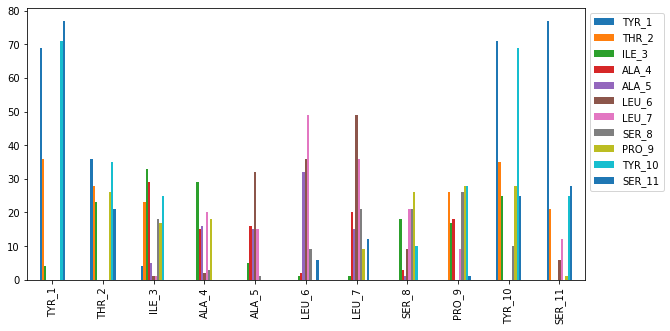

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

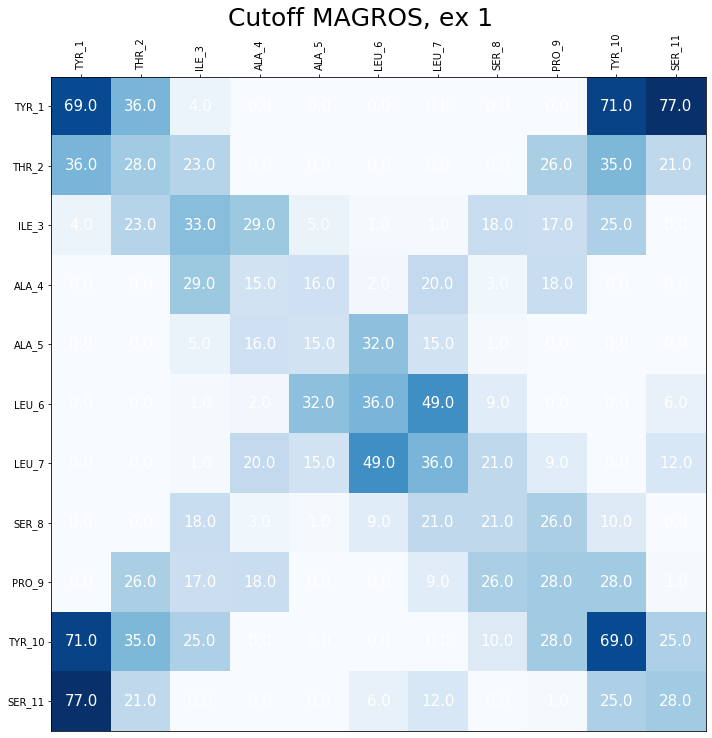

In [6]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
fig.tight_layout()

In [7]:
# Making a normalized dataframe and matrix
histo_df_norm = histo_df.div(histo_df.max().max())
pd.options.display.float_format = '{:.2f}'.format
print(histo_df_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.90   0.47   0.05   0.00   0.00   0.00   0.00   0.00   0.00    0.92    1.00
THR_2    0.47   0.36   0.30   0.00   0.00   0.00   0.00   0.00   0.34    0.45    0.27
ILE_3    0.05   0.30   0.43   0.38   0.06   0.01   0.01   0.23   0.22    0.32    0.00
ALA_4    0.00   0.00   0.38   0.19   0.21   0.03   0.26   0.04   0.23    0.00    0.00
ALA_5    0.00   0.00   0.06   0.21   0.19   0.42   0.19   0.01   0.00    0.00    0.00
LEU_6    0.00   0.00   0.01   0.03   0.42   0.47   0.64   0.12   0.00    0.00    0.08
LEU_7    0.00   0.00   0.01   0.26   0.19   0.64   0.47   0.27   0.12    0.00    0.16
SER_8    0.00   0.00   0.23   0.04   0.01   0.12   0.27   0.27   0.34    0.13    0.00
PRO_9    0.00   0.34   0.22   0.23   0.00   0.00   0.12   0.34   0.36    0.36    0.01
TYR_10   0.92   0.45   0.32   0.00   0.00   0.00   0.00   0.13   0.36    0.90    0.32
SER_11   1.00   0.27   0.00   0.00   0.00   0.08   0.1

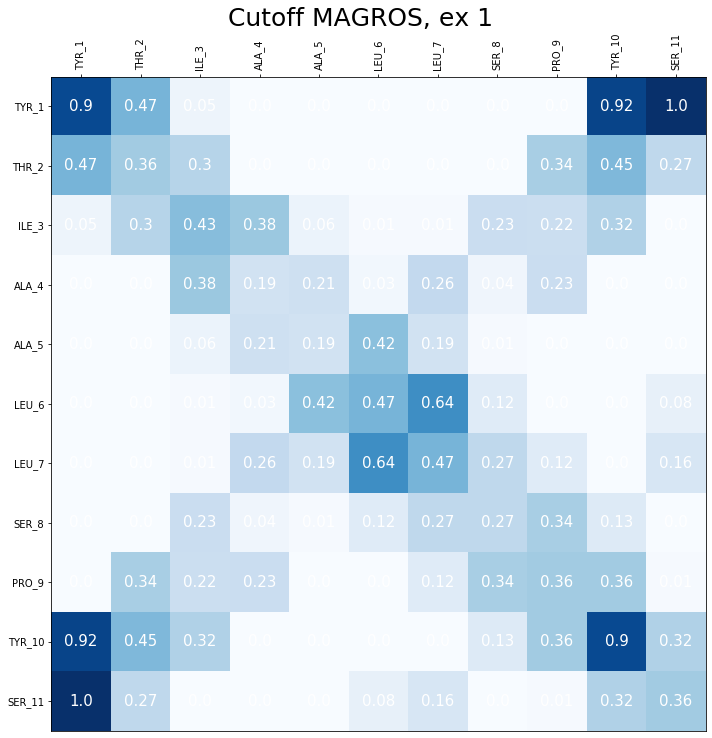

In [8]:
matrix_norm_df = histo_df_norm.to_numpy()
matrix_norm_df = matrix_norm_df.round(decimals = 2)

# plot creation
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_norm_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df_norm.columns)))
ax.set_yticks(np.arange(len(histo_df_norm.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df_norm.columns))
ax.set_yticklabels(list(histo_df_norm.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df_norm.index)):
    for j in range(len(histo_df_norm.columns)):
        text = ax.text(j,i, matrix_norm_df[i,j], ha='center', va='center', color='w', fontsize = 15)
plt.suptitle(f'Cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
fig.tight_layout()

In [9]:
# Sigmas dataframe preparation

pd.options.display.float_format = '{:,.5f}'.format
histo_sigma = pd.DataFrame(sigma_histogram)
histo_sigma = histo_sigma.apply(pd.to_numeric)
histo_sigma[''] = histo_sigma.index.astype(str)
histo_sigma[''] = histo_sigma[''].str.split('_').str[1].astype(int)
histo_sigma.sort_values(by = [''], inplace = True)
histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
histo_sigma.columns = list(amino_dict_num.values())
print(histo_sigma.to_string())


         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.40433 0.42099 0.50838     nan     nan     nan     nan     nan     nan 0.43988 0.39227
THR_2  0.42099 0.40892 0.44751     nan     nan     nan     nan     nan 0.43935 0.42104 0.42697
ILE_3  0.50838 0.44751 0.41917 0.42018 0.50236 0.45622 0.51213 0.42632 0.44319 0.41390     nan
ALA_4      nan     nan 0.42018 0.38584 0.42648 0.51075 0.43341 0.49624 0.44918     nan     nan
ALA_5      nan     nan 0.50236 0.42648 0.38531 0.42402 0.44697 0.49957     nan     nan     nan
LEU_6      nan     nan 0.45622 0.51075 0.42402 0.39863 0.41469 0.48009     nan     nan 0.43918
LEU_7      nan     nan 0.51213 0.43341 0.44697 0.41469 0.40440 0.44905 0.48466     nan 0.45882
SER_8      nan     nan 0.42632 0.49624 0.49957 0.48009 0.44905 0.40248 0.43891 0.46350     nan
PRO_9      nan 0.43935 0.44319 0.44918     nan     nan 0.48466 0.43891 0.39599 0.43859 0.50621
TYR_10 0.43988 0.42104 0.41390     nan     nan    

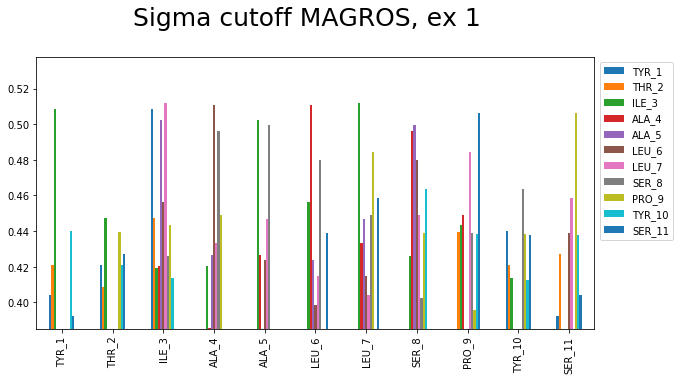

0.38530626305130966


In [10]:
histo_sigma.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_sigma.min()).min())
plt.suptitle(f'Sigma cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_sigma.min()).min())

In [11]:
# Distance dataframe preparation

histo_distance = histo_sigma.apply(lambda a: a*(2**(1/6)))
histo_distance[''] = histo_distance.index.astype(str)
histo_distance[''] = histo_distance[''].str.split('_').str[1].astype(int)
histo_distance.sort_values(by = [''], inplace = True)
histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
histo_distance.columns = list(amino_dict_num.values())
print(histo_distance.to_string())

         TYR_1   THR_2   ILE_3   ALA_4   ALA_5   LEU_6   LEU_7   SER_8   PRO_9  TYR_10  SER_11
TYR_1  0.45384 0.47255 0.57063     nan     nan     nan     nan     nan     nan 0.49375 0.44031
THR_2  0.47255 0.45900 0.50231     nan     nan     nan     nan     nan 0.49315 0.47261 0.47925
ILE_3  0.57063 0.50231 0.47051 0.47164 0.56388 0.51209 0.57485 0.47853 0.49746 0.46459     nan
ALA_4      nan     nan 0.47164 0.43309 0.47871 0.57330 0.48648 0.55701 0.50418     nan     nan
ALA_5      nan     nan 0.56388 0.47871 0.43249 0.47594 0.50171 0.56075     nan     nan     nan
LEU_6      nan     nan 0.51209 0.57330 0.47594 0.44744 0.46547 0.53889     nan     nan 0.49296
LEU_7      nan     nan 0.57485 0.48648 0.50171 0.46547 0.45393 0.50404 0.54401     nan 0.51500
SER_8      nan     nan 0.47853 0.55701 0.56075 0.53889 0.50404 0.45177 0.49266 0.52027     nan
PRO_9      nan 0.49315 0.49746 0.50418     nan     nan 0.54401 0.49266 0.44448 0.49230 0.56820
TYR_10 0.49375 0.47261 0.46459     nan     nan    

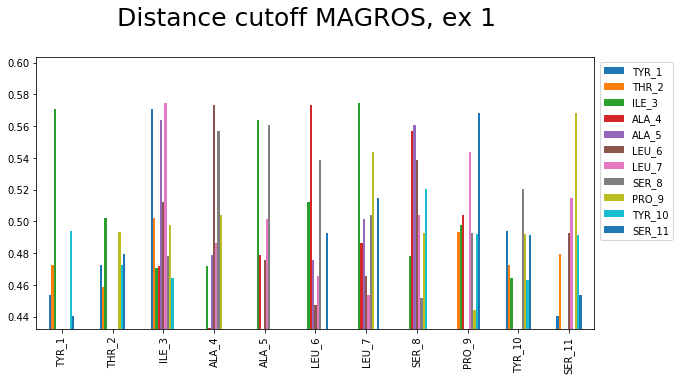

0.43249165725100314


In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_distance.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.ylim(bottom=(histo_distance.min()).min())
plt.suptitle(f'Distance cutoff {plot_cutoff}, ex {exclusion}', fontsize = 25, y = 1.02)
plt.show()
print((histo_distance.min()).min())